In [1]:
#import needed packages
import numpy as np; import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm
import math
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp, odeint
from scipy import stats
import seaborn as sns
import param

## Relatively Simple Climate Model

In [2]:
class layer(param.Parameterized):
    th = param.Number(default=1000, doc="Thickness of the layer, m")
    k = param.Number(default=0, doc="absorbtion coefficient of the layer, m^-1")
    T = param.Number(default=288, doc="Temperature of the layer, K")
    Cp = param.Number(default=1, doc="Heat capacity of the layer, J/(mol K)")
    em = param.Number(default=0.9, doc="Emissivity of the layer")
    sigma = param.Number(default=5.67e-8, doc="Stefan-Boltzmann constant, W/(m^2 K^4)")
    ref = param.Number(default=0.5, doc="Reflectivity of the layer")
    rad = param.Number(default=1, doc="Radius to edge of layer closest to center, m")
    Rg = param.Number(default=8.314, doc="Ideal gas constant, J/(mol K)", constant = True)
    hconv = param.Number(default=10, doc="Convection coefficient, W/(m^2 K)")
    solid = param.Boolean(default=False, doc="Is the layer solid?")
    solidensity  = param.Number(default=1500, doc="Density of the solid, kg/m^3")
    MW = param.Number(default=0.0558, doc="Molecular weight of the component, kg/mol")

    def area(self): #area for the emission to the surroundings taken to be the outside surface area
        return 4*np.pi*(self.rad+self.th)**2

    def moles(self,pressure):
        volume = 4/3*np.pi*((self.rad+self.th)**3 - (self.rad)**3)
        if self.solid:
            return self.solidensity*volume/self.MW
        else:
            return pressure*volume/(self.Rg*self.T)
    
    def adsorbed(self,Ii): # energy adsorbed by the layer
        return Ii*((1-self.ref)-(1-self.ref)**2*np.exp(-self.k*self.th))*self.area() #Ii is the intensity of the incoming radiation
    
    def emitted(self,Tsurr): # energy radiated by the layer to the surroundings
        return self.em*self.sigma*self.area()*(self.T**4 - Tsurr**4)
    
    def convection(self,upperlayer, lowerlayer): # energy convected by the layer to the other layers
        hc_u = (self.hconv + upperlayer.hconv)/2
        hc_l = (self.hconv + lowerlayer.hconv)/2
        area_u = self.area(); area_l = 4*np.pi*(self.rad)**2
        if upperlayer == self:
            heat_u = hc_u*(self.T - 250)*area_u #heat lost to space from the top layer
        elif lowerlayer == self:
            heat_u = hc_u*(self.T - 290)*area_u #mimicking heat from the earth's core to the bottom layer
        else:
            heat_u = hc_u*(self.T - upperlayer.T)*area_u
        heat_l = hc_l*(self.T - lowerlayer.T)*area_l
        return heat_u + heat_l
    
    def dTdt(self,Ii,Tsurr,pressure,upperlayer,lowerlayer): # change in temperature with time of the layer
        conv = self.convection(upperlayer, lowerlayer)
        return (self.adsorbed(Ii) - self.emitted(Tsurr) - conv)/(self.moles(pressure)*self.Cp)    

In [3]:
#Now simulate the layers with a given intensity of incoming radiation and 
# a given temperature of the surroundings
years = 10
time = np.linspace(0,365*years,3650*years) #days 
Tsurr = 100 #K
pressure = 1e5 #Pa
hc = 100 #W/(m^2 K) #convection coefficient for all layers
radius = 100 #m, radius of the planet
initial_temps = [256+4.8, 263+5.4, 286] #initial temperatures of the layers
dryair = layer(th=90, k = 0.01, T = initial_temps[0], Cp = 29, em = 0.3, ref = 0.02, rad = radius+30+1, hconv = hc)
wetair = layer(th=30, k = 0.7, T = initial_temps[1], Cp = 36, em = 0.8, ref = 0.2, rad = radius+1, hconv = hc)
iron = layer(th=1, k = 100, T = initial_temps[2], Cp = 25, em = 0.5, ref = 0, rad = radius, hconv = 1, solid=True)

In [21]:
initial_temps

[260.8, 268.4, 286]

In [4]:
#set radiation intensity
Io = 1.5e3 #W/m^2
def Ii(day):
    #return (np.sin(2*np.pi*day)+1)*Io/2 #W/m^2  
    return (np.sin(2*np.pi*day*1e-8)+1)+Io #W/m^2 

Text(0, 0.5, 'Intensity of incoming radiation (W/m^2)')

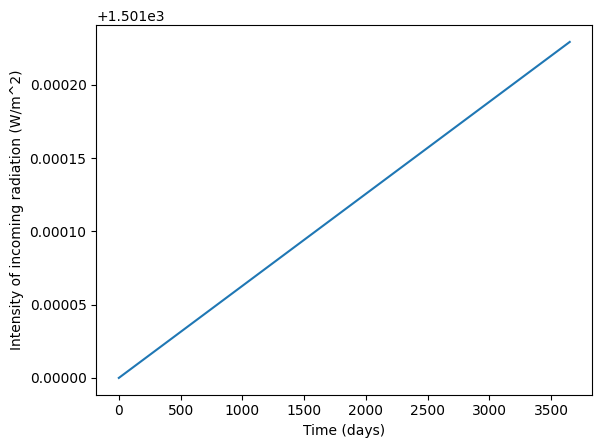

In [5]:
plt.plot(time,Ii(time))
plt.xlabel("Time (days)"); plt.ylabel("Intensity of incoming radiation (W/m^2)")
#plt.xlim([1000,1035])

In [6]:
#Integrate the differential equations using ODEINT
def derivs(T,t,Ii):
    [dryair.T,wetair.T,iron.T] = T #set the temperatures of the layers from the odeint results
    #ad(t) #change the absorption coefficient of dryair
    #refl(t) #change the reflectivity of wetair
    I0 = Ii(t)
    I1 = Ii(t)*(1-dryair.ref)**2*np.exp(-dryair.k*dryair.th)
    I2 = I1*(1-wetair.ref)**2*np.exp(-wetair.k*wetair.th)
    dryair.k += 0.000002 #simulate gradual increase in CO2 concentration
    wetair.k += 0.000002 #simulate gradual increase in CO2 concentration
    return [dryair.dTdt(I0,Tsurr,pressure,dryair,wetair), \
        wetair.dTdt(I1,Tsurr,pressure,dryair,iron), \
            iron.dTdt(I2,Tsurr,pressure,wetair,iron)]
T0 = [dryair.T,wetair.T,iron.T]
args = (Ii,)
results = odeint(derivs,T0,time,args)
first = np.array([each[0] for each in results])
second = np.array([each[1] for each in results])
third = np.array([each[2] for each in results])

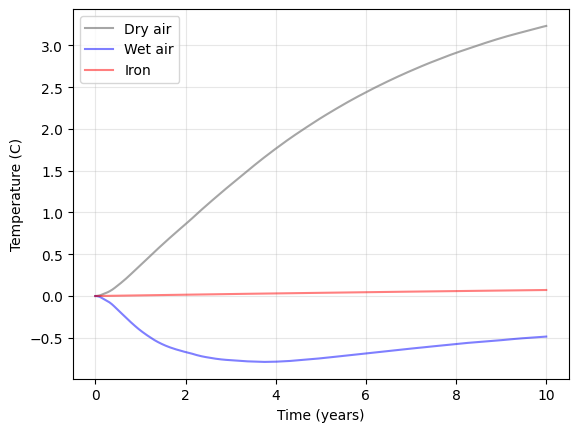

In [ ]:
#Plot the results
plt.plot(time/365,first-initial_temps[0],label = "Dry air",color='grey',alpha=0.7)
plt.plot(time/365,second-initial_temps[1],label = "Wet air",color='blue',alpha=0.5)
plt.plot(time/365,third-initial_temps[2],label = "Iron",color='red',alpha=0.5)
plt.xlabel("Time (years)")
plt.ylabel("Temperature (C)")
plt.legend(); plt.grid(alpha=0.3)
#plt.savefig("ClimateSimulatedTempRise.png",dpi=300)
plt.show()

In [8]:
#changes in temperature
(dryair.T-initial_temps[0],wetair.T-initial_temps[1],iron.T-initial_temps[2])

(3.233358207200638, -0.48526461595184855, 0.07213120283978469)

In [9]:
(-0.02662117706540812, 0.043339794024348066, 0.07598497441011887) #above values with no increase in ks


(-0.02662117706540812, 0.043339794024348066, 0.07598497441011887)

In [10]:
dryair.k,wetair.k

(0.03009199999999012, 0.7200919999994624)

## Air Quality Data 1990 and 2025

In [40]:
#read in data for air quality
data1990 = pd.read_csv("daily_49_049_4001_1990.csv")
data2014 = pd.read_csv("daily_49_049_4001_2014.csv")
data2024 = pd.read_csv("daily_49_049_4001_2024.csv")

In [41]:
data1990.columns

Index(['State Code', 'County Code', 'Site Number', 'Parameter Code', 'POC',
       'Latitude', 'Longitude', 'Datum', 'Parameter Name',
       'Duration Description', 'Pollutant Standard', 'Date (Local)', 'Year',
       'Day In Year (Local)', 'Units of Measure', 'Exceptional Data Type',
       'Nonreg Observation Count', 'Observation Count', 'Observation Percent',
       'Nonreg Arithmetic Mean', 'Arithmetic Mean',
       'Nonreg First Maximum Value', 'First Maximum Value',
       'First Maximum Hour', 'AQI', 'Daily Criteria Indicator', 'Tribe Name',
       'State Name', 'County Name', 'City Name', 'Local Site Name', 'Address',
       'MSA or CBSA Name', 'Data Source'],
      dtype='object')

In [42]:
#Print head when parameter code is 81102 and when Pollutant is "PM10 24-hour 2006"
df1990 = data1990[(data1990['Parameter Code'] == 81102) & (data1990['Pollutant Standard'] == "PM10 24-hour 2006")]
df2014 = data2014[(data2014['Parameter Code'] == 81102) & (data2014['Pollutant Standard'] == "PM10 24-hour 2006")]
df2024 = data2024[(data2024['Parameter Code'] == 81102) & (data2024['Pollutant Standard'] == "PM10 24-hour 2006")]

In [46]:
#create a column for day count from january for each dataframe
df1990['DayCount'] = pd.to_datetime(data1990['Date (Local)']).dt.dayofyear
df2014['DayCount'] = pd.to_datetime(data2014['Date (Local)']).dt.dayofyear
df2024['DayCount'] = pd.to_datetime(data2024['Date (Local)']).dt.dayofyear

/var/folders/6d/1jr2w1qx1rnd2nkndlq4hc700000gn/T/ipykernel_59663/1772251855.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2014['DayCount'] = pd.to_datetime(data2014['Date (Local)']).dt.dayofyear
/var/folders/6d/1jr2w1qx1rnd2nkndlq4hc700000gn/T/ipykernel_59663/1772251855.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2024['DayCount'] = pd.to_datetime(data2024['Date (Local)']).dt.dayofyear


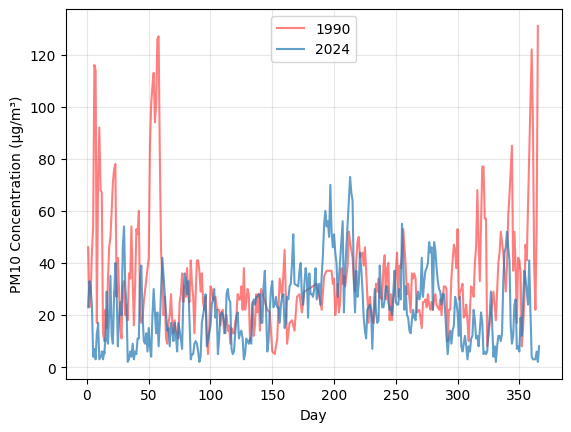

In [53]:
#Plot the date(local) versus Arithmetic Mean column
plt.plot(df1990['DayCount'],df1990['Arithmetic Mean'],label='1990',color='red',alpha=0.5)
#plt.plot(df2014['DayCount'],df2014['Arithmetic Mean'],label='2014',alpha=0.7)
plt.plot(df2024['DayCount'],df2024['Arithmetic Mean'],label='2024',alpha=0.7)
plt.xlabel("Day"); plt.ylabel("PM10 Concentration (µg/m³)")
plt.legend(); plt.grid(alpha=0.3)

In [66]:
#read in data for air quality
aaqd = pd.read_csv("EPAAirQualityUtahCounty.csv")

In [67]:
aaqd.head()

,Day,Value,Indicator,Year
0,1,24.0,"PM10, ug/m3",2024
1,2,33.0,"PM10, ug/m3",2024
2,3,31.0,"PM10, ug/m3",2024
3,4,24.0,"PM10, ug/m3",2024
4,5,5.0,"PM10, ug/m3",2024


In [72]:
#calculate the mean concentrations by year
aaqd.groupby(['Year','Indicator'])['Value'].mean().unstack()

Indicator,"CO, ppm x 100","NOx, ppb","PM10, ug/m3"
Year,,,
1993,112.917671,NaN,40.017094
2014,53.371281,29.302677,21.304878
2024,29.608898,9.884859,22.329545


In [ ]:
#if indicator is CO, ppm, multiply it by 100 and then rename the indicator to CO, ppm x 100
indicator_col='Indicator'; value_col='Value'
# 1. Identify the rows where the indicator is 'CO, ppm'
condition = aaqd[indicator_col] == 'CO, ppm'
# 2. Multiply the 'Value' by 100 for those specific rows
aaqd.loc[condition, value_col] = aaqd.loc[condition, value_col] * 100
# 3. Rename the 'Indicator' for those specific rows
aaqd.loc[condition, indicator_col] = 'CO, ppm x 100'

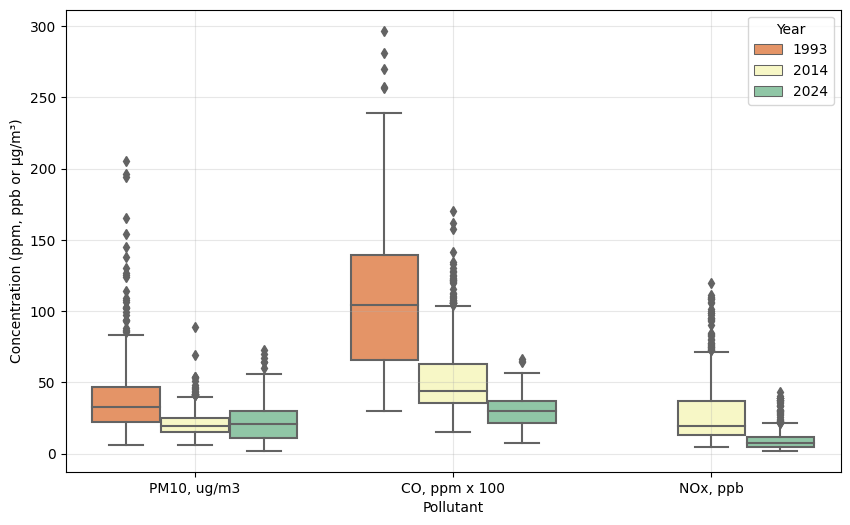

In [ ]:
# create seaborn boxplot of concentrations of CO, NOx, and PM10 by year
plt.figure(figsize=(10,6))
sns.boxplot(x='Indicator', y='Value', hue='Year', data=aaqd, palette="Spectral")
plt.xlabel("Pollutant"); plt.ylabel("Concentration (ppm, ppb or µg/m³)")
plt.grid(alpha=0.3)
#plt.savefig("AirQualityBoxplot.png",dpi=300)
plt.show()

In [ ]:
condition1 = (aaqd['Indicator'] == 'PM10, ug/m3') & (aaqd['Year'] == 1993)
condition2 = (aaqd['Indicator'] == 'PM10, ug/m3') & (aaqd['Year'] == 2024)

t_stat, p_value = stats.ttest_ind(aaqd.loc[condition1,'Value'], aaqd.loc[condition2,'Value'], equal_var=True)
p_value